In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import random
import mutation
import crossover
import generator
import fitness
import csv
from datetime import datetime

In [2]:
# user given constants
src=0
dst=1
bandwidth_threshold = 2
# parameters
generation = 1000
max_depth = 5
k_shortest = 5
random_walk_mult = 2

In [3]:
random.seed(datetime.now())

In [4]:
#Read file related to testing
def get_test_file():
    '''Generator that return string of file name'''
    import re
    for files in os.listdir():
        if re.match('test.+\.csv', files) is not None:
            yield files
            
def csv_to_np(filename):
    return pd.read_csv(filename, header=None, delim_whitespace=True).values

# Use generator if file does not exist
try:
    print('Using existing generated matrix')
    bandwidth_matrix = csv_to_np('generated.csv')
except:
    print('Generating new bandwidth matrix!!!!!!!!!!!')
    bandwidth_matrix = generator.generate("random", (1, 100), n=1000, p=0.1).out(type="2d_list")
    with open("generated.csv","w") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=' ')
        csvWriter.writerows(bandwidth_matrix)

#bandwidth_matrix = csv_to_np('test1.csv')
#print(type(bandwidth_matrix), '\n', bandwidth_matrix)

Using existing generated matrix


In [5]:
def np_to_nx(bandwidth_matrix):
    # build neighbor matrix
    neighbor_matrix = []
    for row, _ in enumerate(bandwidth_matrix):
        neighbor_matrix.append(np.where(bandwidth_matrix[row] > 0)[0])
    neighbor_matrix = np.array(neighbor_matrix)
    
    # build the list of edges
    edges = np.array(np.where(bandwidth_matrix > 0)).transpose()

    # build nx Graph instance
    G = nx.Graph()
    num_of_nodes = bandwidth_matrix.shape[0]
    G.add_nodes_from(range(num_of_nodes))
    G.add_edges_from(edges)
    return G, neighbor_matrix
    
G, neighbor_matrix = np_to_nx(bandwidth_matrix)

/home/phua/anaconda3/envs/evo/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


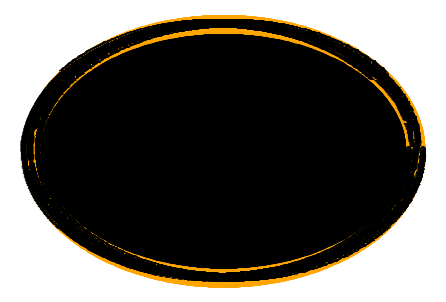

In [6]:
def nx_visualize(G):
    # Visualize the graph
    %matplotlib inline
    nx.draw_shell(G, with_labels=True, node_color='orange')

nx_visualize(G)

In [7]:
def random_walk(src, dest, min_step, neighbor_matrix):
    path=[src]
    #for i in range(step):
    while(True):
        next_node = random.choice(neighbor_matrix[path[-1]])
        path.append(next_node)
        
        if len(path) > min_step and path[-1] == dest:
            break
    return crossover.check_cycle(path)

In [8]:
def get_path_length(pop):
    # count path length of each individual
    path_length = []
    for ind in pop:
        path_length.append(len(ind))
    return path_length

In [9]:
def initial(G, s, d, iddfs_depth, population_size, neighbor_matrix):
    population = []
    for i in range(population_size):
        new_ind = random_walk(s, d, random_walk_mult * G.order(), neighbor_matrix)
        population.append(new_ind)
    return population

In [10]:
# Edge density of graph
# This is for calculating parameter (但現在還沒做)
edge_density = G.size()*2/G.order()*(G.order()-1)
print(edge_density)

100387.512


In [11]:
candidate = np.linspace(0.1,0.2, num=2)
candidate = [0.1]
for ratio in candidate:
    population_size = min(200, max(int(ratio * edge_density), k_shortest))
    # for example, given src=0, dst=3, max_depth=7, population_size=20
    pop = initial(G, src, dst, max_depth, population_size, neighbor_matrix)
print('Path length for each initial individual:', get_path_length(pop))

Path length for each initial individual: [35, 38, 43, 29, 31, 13, 35, 35, 27, 36, 36, 17, 20, 46, 50, 41, 44, 42, 33, 21, 22, 13, 95, 19, 53, 9, 61, 52, 43, 28, 73, 63, 51, 61, 20, 44, 32, 46, 56, 43, 78, 39, 27, 35, 24, 62, 16, 36, 84, 20, 28, 14, 44, 32, 71, 36, 35, 44, 34, 48, 11, 22, 36, 21, 46, 77, 22, 18, 23, 20, 38, 80, 9, 15, 59, 27, 95, 41, 75, 20, 44, 45, 107, 40, 67, 74, 15, 62, 21, 91, 37, 45, 43, 44, 29, 37, 52, 26, 30, 44, 49, 18, 62, 70, 63, 46, 50, 36, 8, 60, 49, 19, 48, 28, 27, 36, 36, 26, 25, 71, 107, 30, 90, 21, 43, 22, 57, 42, 59, 8, 23, 40, 35, 28, 70, 32, 32, 27, 34, 50, 12, 34, 36, 40, 77, 86, 38, 22, 43, 14, 39, 70, 12, 27, 59, 22, 9, 25, 19, 22, 22, 8, 60, 52, 74, 14, 20, 37, 19, 65, 30, 25, 36, 53, 104, 19, 5, 59, 43, 63, 21, 32, 13, 27, 76, 51, 52, 52, 30, 40, 63, 39, 43, 5, 42, 24, 12, 30, 106, 24]


In [12]:
# main loop
fit_v_gen = []
for g in range(generation):
    #display(pd.DataFrame(fitness.population_with_fitness(pop, bandwidth_matrix)))
    
    # crossover
    temp_pop = []
    for idx in range(len(pop)-1):
        child1, child2 = crossover.random_crossover(pop[idx], pop[idx+1], bandwidth_matrix)
        temp_pop += [crossover.check_cycle(child1), crossover.check_cycle(child2)]
    
    # mutation
    children_pop = []
    for ind in pop:
        children_pop.append(crossover.check_cycle(mutation.mutation(neighbor_matrix, ind)))

    # diversity maintenance
    pop = np.unique(pop+temp_pop+children_pop).tolist()
    
    # fitness evaluation
    pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)
    
    # selection
    pop = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
    fit_v_gen.append(np.mean(pop['fitness'][:k_shortest]))
    #display(pop)
    pop = pop['individual'][0:population_size].tolist()



In [13]:
pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)
rst = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
rst['hop'] = get_path_length(pop)
rst.head(k_shortest)

,fitness,individual,hop
0,55878,"[0, 367, 359, 1]",4
1,47947,"[0, 9, 422, 825, 1]",5
2,47947,"[0, 367, 422, 825, 1]",5
3,47947,"[0, 652, 527, 825, 1]",5
4,43221,"[0, 889, 808, 982, 1]",5


In [14]:
# Ref: https://pythonhealthcare.org/tag/pareto-front/
def identify_pareto(scores):
    
    # flip num_of_hops to negative so that we can maxmize it
    scores[:,1] = -scores[:,1]
    
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
   
    # Add the right-most & down-most points
    max_bandwidth = max(scores[:, 0])
    min_length = max(scores[:, 1])

    for i in range(population_size):
        if scores[i][0] == max_bandwidth or scores[i][1] == min_length:
            pareto_front[i] = 1
    
    
    # flip back the negative sign of num_of_hops
    scores[:,1] = -scores[:,1]
    
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]


In [15]:
data = rst.drop(columns='individual').values
front_idx = identify_pareto(data)
pareto_front= data[front_idx]
pareto_front.sort(axis=0)
pareto_front

array([[10142,     3],
       [55878,     4]])

In [16]:
all(data[0] > data[1]) 

False

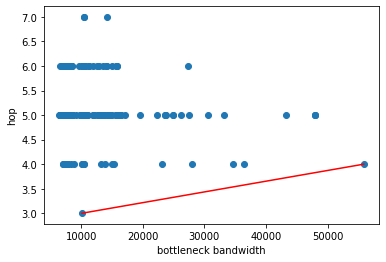

In [17]:
import matplotlib.pyplot as plt
plt.scatter(rst['fitness'], rst['hop'])
plt.plot(pareto_front[:, 0], pareto_front[:, 1], color='r')
plt.xlabel('bottleneck bandwidth')
plt.ylabel('hop')
plt.show()
#plt.

In [18]:
rst

,fitness,individual,hop
0,55878,"[0, 367, 359, 1]",4
1,47947,"[0, 9, 422, 825, 1]",5
2,47947,"[0, 367, 422, 825, 1]",5
3,47947,"[0, 652, 527, 825, 1]",5
4,43221,"[0, 889, 808, 982, 1]",5
5,36372,"[0, 652, 169, 1]",4
6,34710,"[0, 981, 359, 1]",4
7,33218,"[0, 164, 699, 982, 1]",5
8,30581,"[0, 302, 602, 825, 1]",5
9,28002,"[0, 164, 290, 1]",4


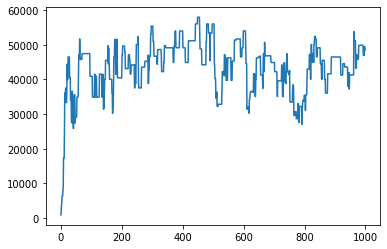

In [19]:
plt.plot(fit_v_gen)

In [20]:
max_band = max(bandwidth_matrix.flatten())
np.where(bandwidth_matrix==max_band)

(array([ 80, 741]), array([741,  80]))

In [21]:
print(bandwidth_matrix[0][367])
print(bandwidth_matrix[367][359])
print(bandwidth_matrix[359][1])

92978
55878
1787154


In [22]:
G.order()

1000